**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KDTree
from sklearn import preprocessing #для стандартизации

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:

    
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm):
        self.n = n_neighbors
        self.alg = algorithm
    
    def fit(self, X, y):
        self.X_train = X
        self.scaler = preprocessing.StandardScaler().fit(self.X_train) 
        self.X_train_st = self.scaler.transform(self.X_train)
        self.y_train = y
        self.min_length = np.unique(self.y_train)[-1]+1
        
    def predict(self, X):
        self.X_test = X
        self.X_test_st = self.scaler.transform(self.X_test)
        self.y_pred = np.zeros(self.X_test_st.shape[0],dtype='int64')
        if(self.alg == 'brute'):
            for i in range(self.X_test_st.shape[0]):
                a = self.X_train_st - self.X_test_st[i,:]
                dist = np.linalg.norm(a, axis=1)
                ind = np.argsort(dist)[:self.n]
                self.y_pred[i] = np.argmax(np.bincount(self.y_train[ind],minlength = self.min_length))
        else:
                self.KDTree = KDTree(self.X_train_st)
                dist, ind = self.KDTree.query(self.X_test_st, k=self.n)
                self.y_pred = np.argmax(np.apply_along_axis(lambda x: np.bincount(x, minlength=self.min_length), 1, self.y_train[ind]), axis=1)
        return self.y_pred.ravel()
        
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [8]:
my_acc=0
acc=0
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    #print( accuracy_score(y_test, my_clf_pred)>=accuracy_score(y_test, sklearn_pred), accuracy_score(y_test, my_clf_pred),accuracy_score(y_test, sklearn_pred))
    my_acc+=accuracy_score(y_test, my_clf_pred)
    acc+=accuracy_score(y_test, sklearn_pred)
print(my_acc/100.0,acc/100.0)

0.9373333333333328 0.9366666666666664


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [10]:
%time my_clf.fit(X_train, y_train)

Wall time: 1.72 ms


In [11]:
%time clf.predict(X_test)

Wall time: 3 ms


array([2, 0, 0, 2, 2, 1, 0, 1, 1, 2, 0, 1, 0, 1, 1])

In [12]:
%time my_clf.predict(X_test)

Wall time: 2.25 ms


array([2, 0, 0, 2, 2, 1, 0, 1, 1, 2, 0, 1, 0, 1, 1], dtype=int64)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

Wall time: 4.01 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [16]:
%time my_clf.fit(X_train, y_train)

Wall time: 2 ms


In [17]:
%time clf.predict(X_test)

Wall time: 5 ms


array([0, 0, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 2, 1])

In [18]:
%time my_clf.predict(X_test)

Wall time: 1 ms


array([0, 0, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 2, 1], dtype=int64)

In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [20]:
my_acc=0
acc=0
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    #print( accuracy_score(y_test, my_clf_pred)>=accuracy_score(y_test, sklearn_pred), accuracy_score(y_test, my_clf_pred),accuracy_score(y_test, sklearn_pred))
    my_acc+=accuracy_score(y_test, my_clf_pred)
    acc+=accuracy_score(y_test, sklearn_pred)
print(my_acc/100.0,acc/100.0)

0.9506666666666662 0.9506666666666663


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [21]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [22]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [23]:
from sklearn import feature_extraction
vectorizer = feature_extraction.text.CountVectorizer(max_df = 0.2, min_df=0.05)
X = vectorizer.fit_transform(data)
X

<11314x186 sparse matrix of type '<class 'numpy.int64'>'
	with 192487 stored elements in Compressed Sparse Row format>

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [24]:
#разбиение выборки на 3 блока
from sklearn.model_selection import KFold
kfold = KFold(3,True)

for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]

TRAIN: [    0     1     4 ... 11310 11311 11313] TEST: [    2     3     6 ... 11302 11308 11312]
TRAIN: [    0     2     3 ... 11310 11311 11312] TEST: [    1     5     7 ... 11301 11305 11313]
TRAIN: [    1     2     3 ... 11308 11312 11313] TEST: [    0     4     8 ... 11309 11310 11311]


In [25]:
import matplotlib.pyplot as plt
#для быстроты посчитаем на кд_дереве 
def best_k(X,n_max):
    neigbours = list(range(1,n_max+1,1))
    accuracy=np.zeros(n_max)
    i=0
    for k in neigbours:
        my_clf = MyKNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = target[train_index], target[test_index]
            my_clf.fit(X_train.toarray(), y_train)
            my_clf_pred = my_clf.predict(X_test.toarray())
            accuracy[i]+=accuracy_score(y_test, my_clf_pred)
        accuracy[i]/=3
        i+=1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = np.arange(1,16)
    y = accuracy
    ax.plot(x,y)
    plt.show()
#выводим скор и лучшее кол-во соседей
    return np.argmax(accuracy[1:])+2


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

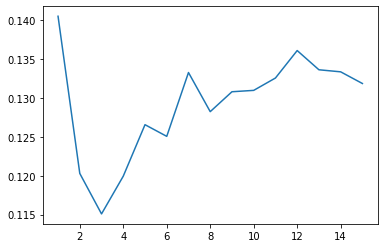

12

In [26]:
best_k(X,15)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [27]:
#переписала для использования косинусной метрики
class MyKNeighborsClassifier_cosine(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm):
        self.n = n_neighbors
        self.alg = algorithm
    
    def fit(self, X, y):
        self.X_train = X
        self.scaler = preprocessing.StandardScaler().fit(self.X_train) 
        self.X_train_st = self.scaler.transform(self.X_train)
        self.y_train = y
        self.min_length = np.unique(self.y_train)[-1]+1
        
    def predict(self, X):
        self.X_test = X
        self.X_test_st = self.scaler.transform(self.X_test)
        self.y_pred = np.zeros(self.X_test_st.shape[0],dtype='int64')
        if(self.alg == 'brute'):
            for i in range(self.X_test_st.shape[0]):
                a = self.X_train_st
                b = self.X_test_st[i,:]
                dist = 1.0-(np.sum(a*b,axis=1)/(np.sqrt(np.sum(a*a,axis=1))*np.sqrt(np.sum(b*b))))
                ind = np.argsort(dist)[:self.n]
                self.y_pred[i] = np.argmax(np.bincount(self.y_train[ind],minlength = self.min_length))
        else:
                self.KDTree = KDTree(self.X_train_st)
                dist, ind = self.KDTree.query(self.X_test_st, k=self.n)
                self.y_pred = np.argmax(np.apply_along_axis(lambda x: np.bincount(x, minlength=self.min_length), 1, self.y_train[ind]), axis=1)
        return self.y_pred.ravel()
        
                    

In [28]:
my_clf2 = MyKNeighborsClassifier_cosine(n_neighbors=10, algorithm='brute')
for train_index, test_index in kfold.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = target[train_index], target[test_index]
    my_clf.fit(X_train.toarray(), y_train)
    my_clf_pred = my_clf.predict(X_test.toarray())
    my_clf2.fit(X_train.toarray(), y_train)
    my_clf2_pred = my_clf2.predict(X_test.toarray())
    print( accuracy_score(y_test, my_clf_pred), accuracy_score(y_test, my_clf2_pred))

TRAIN: [    0     1     3 ... 11309 11311 11312] TEST: [    2     4     7 ... 11308 11310 11313]
0.12195121951219512 0.16092258748674443
TRAIN: [    0     2     3 ... 11311 11312 11313] TEST: [    1     8     9 ... 11304 11307 11309]
0.12649164677804295 0.16759480243967118
TRAIN: [    1     2     4 ... 11309 11310 11313] TEST: [    0     3     5 ... 11305 11311 11312]
0.12118801378944577 0.15645717316361707


In [29]:
#1.видим что точность подросла

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df = 0.2, min_df=0.05)
X2 = vectorizer.fit_transform(data)
my_clf2 = MyKNeighborsClassifier_cosine(n_neighbors=10, algorithm='brute')
for train_index, test_index in kfold.split(X2):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X2[train_index], X2[test_index]
    y_train, y_test = target[train_index], target[test_index]
    my_clf.fit(X_train.toarray(), y_train)
    my_clf_pred = my_clf.predict(X_test.toarray())
    my_clf2.fit(X_train.toarray(), y_train)
    my_clf2_pred = my_clf2.predict(X_test.toarray())
    print( accuracy_score(y_test, my_clf_pred), accuracy_score(y_test, my_clf2_pred))

TRAIN: [    0     1     6 ... 11309 11311 11313] TEST: [    2     3     4 ... 11305 11310 11312]
0.1574761399787911 0.18425238600212088
TRAIN: [    1     2     3 ... 11309 11310 11312] TEST: [    0     7     9 ... 11308 11311 11313]
0.1431980906921241 0.18005833996287457
TRAIN: [    0     2     3 ... 11311 11312 11313] TEST: [    1     6     8 ... 11303 11306 11309]
0.15910898965791567 0.19252187748607796


Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [31]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [36]:
my_clf2 = MyKNeighborsClassifier_cosine(n_neighbors=10, algorithm='brute')
vectorizer = TfidfVectorizer(max_df = 0.2, min_df=0.05)
X2 = vectorizer.fit_transform(data)
my_clf2.fit(X2.toarray(), target)
data_test = newsgroups['data']
target_test = newsgroups['target']
X2_test = vectorizer.transform(data_test)


In [37]:
my_clf2_pred = my_clf2.predict(X2_test.toarray())
print(accuracy_score(target_test, my_clf2_pred))

0.16356877323420074


In [ ]:
#качество на тесте может быть ниже т.к. на кросс валидации мы трансформировали весь трейн одинаково и затем из него брали кусочки
#здесь же мы учимся трансформировать на трейне и затем прогоняем тест по этой же трансформации, но наборы слов в трейне и тесте разные
# например, если в трейне очень часто встречалось какое то слово, его вес будет маленьким, при этом в тесте оно могло встречаться редко и только у похожих документов